In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image

#이미지 표시 kernel dead : https://normal-engineer.tistory.com/236

In [2]:
model = models.resnet18(pretrained=False)

C:\Users\noname\anaconda3\envs\sjh\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\noname\anaconda3\envs\sjh\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

file_path = "C:\\Users\\noname\\Desktop\\Casting\\casting_data\\train"
test_path = "C:\\Users\\noname\\Desktop\\Casting\\casting_data\\test"

data = dset.ImageFolder(root=file_path,transform=transform)
data_loader = torch.utils.data.DataLoader(data, batch_size=32,shuffle=True,num_workers=2)

In [4]:
data.len=len(data)
print(data.len)

6633


In [5]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [6]:
# function to calculate number of correct labels
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

# use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# initialize network
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loader = torch.utils.data.DataLoader(
    data
    ,batch_size=500
    ,shuffle=True
)

num_epochs = 100

for epoch in range(num_epochs):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad()
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print("epoch", epoch, "total_correct:", total_correct, "loss:", total_loss)
print('Finished Training')

epoch 0 total_correct: 5311 loss: 19.81840208172798
epoch 1 total_correct: 6259 loss: 2.2758143842220306
epoch 2 total_correct: 6442 loss: 1.14539098367095
epoch 3 total_correct: 6524 loss: 0.732987442985177
epoch 4 total_correct: 6564 loss: 0.4927929062396288
epoch 5 total_correct: 6590 loss: 0.3453690931200981
epoch 6 total_correct: 6583 loss: 0.3499357411637902
epoch 7 total_correct: 6594 loss: 0.24236302869394422
epoch 8 total_correct: 6601 loss: 0.22799707390367985
epoch 9 total_correct: 6609 loss: 0.21839846763759851
epoch 10 total_correct: 6601 loss: 0.22866414859890938
epoch 11 total_correct: 6601 loss: 0.18924472038634121
epoch 12 total_correct: 6614 loss: 0.14155749860219657
epoch 13 total_correct: 6617 loss: 0.1475842088693753
epoch 14 total_correct: 6611 loss: 0.15918408136349171
epoch 15 total_correct: 6602 loss: 0.17099697864614427
epoch 16 total_correct: 6611 loss: 0.1939039514400065
epoch 17 total_correct: 6607 loss: 0.17449339746963233
epoch 18 total_correct: 6617 loss

In [7]:
total_correct = 0
total_images = 0
num_incorrect = 0  # 잘못 분류된 이미지 개수를 저장할 변수

# 예측 수행 및 정확도 계산
with torch.no_grad():
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # 예측 수행
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # 정확도 계산
        total_correct += (predicted == labels).sum().item()
        total_images += labels.size(0)
        
        # 잘못 분류된 이미지 개수 계산
        num_incorrect += torch.sum(predicted != labels).item()

# 전체 정확도 계산
accuracy = total_correct / total_images
print("Accuracy:", accuracy)

# 잘못 분류된 이미지 개수 출력
print("Number of incorrectly classified images:", num_incorrect)

Accuracy: 1.0
Number of incorrectly classified images: 0


In [9]:
from collections import defaultdict

# 클래스별 예측 수를 저장할 딕셔너리 생성
class_prediction_counts = defaultdict(int)
# 클래스별 이미지 개수를 저장할 딕셔너리 생성
class_label_counts = defaultdict(int)

# 예측 수행 및 클래스별 예측 수 계산
total_correct = 0
total_images = 0

with torch.no_grad():
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # 예측 수행
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # 클래스별 예측 수 계산
        for pred in predicted:
            class_prediction_counts[pred.item()] += 1
        
        # 클래스별 이미지 개수 계산
        for label in labels:
            class_label_counts[label.item()] += 1
            
        # 정확도 계산
        total_correct += (predicted == labels).sum().item()
        total_images += labels.size(0)

# 전체 정확도 계산
accuracy = total_correct / total_images

# 클래스별 정확도 계산 및 출력
for class_id, count in class_label_counts.items():
    class_name = classes[class_id]
    predicted_count = class_prediction_counts[class_id]
    class_accuracy = predicted_count / count if count != 0 else 0
    print(f"Class: {class_name}, Predicted count: {predicted_count}, Original count: {count}, Class Accuracy: {class_accuracy}")

# 전체 정확도 출력
print("Overall Accuracy:", accuracy)

Class: Def, Predicted count: 2877, Original count: 2875, Class Accuracy: 1.000695652173913
Class: Ok, Predicted count: 3756, Original count: 3758, Class Accuracy: 0.9994678020223523
Overall Accuracy: 0.9996984773104176


In [10]:
PATH = "C:\\Users\\noname\\Desktop\\Casting_NEW.pth"
torch.save(model.state_dict(), PATH)

In [5]:
PATH = "C:\\Users\\noname\\Desktop\\Casting\\Casting_NEW.pth"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [6]:
test = dset.ImageFolder(root=test_path,transform=transform)
test_loader = torch.utils.data.DataLoader(test, batch_size=32,shuffle=True,num_workers=2)

In [7]:
test.len=len(test)
print(test.len)

715


In [8]:
classes = ("Ok","Def")

num_classes = len(classes)
for i,c in enumerate(classes):
  print("classes[%d] : %s"%(i, c))
print("Number of classes : %d"%(num_classes))

classes[0] : Ok
classes[1] : Def
Number of classes : 2


Number of incorrectly classified images: 3
Accuracy: 0.9958041958041958
Accuracy of Ok : 450/453
Accuracy of Def : 262/262


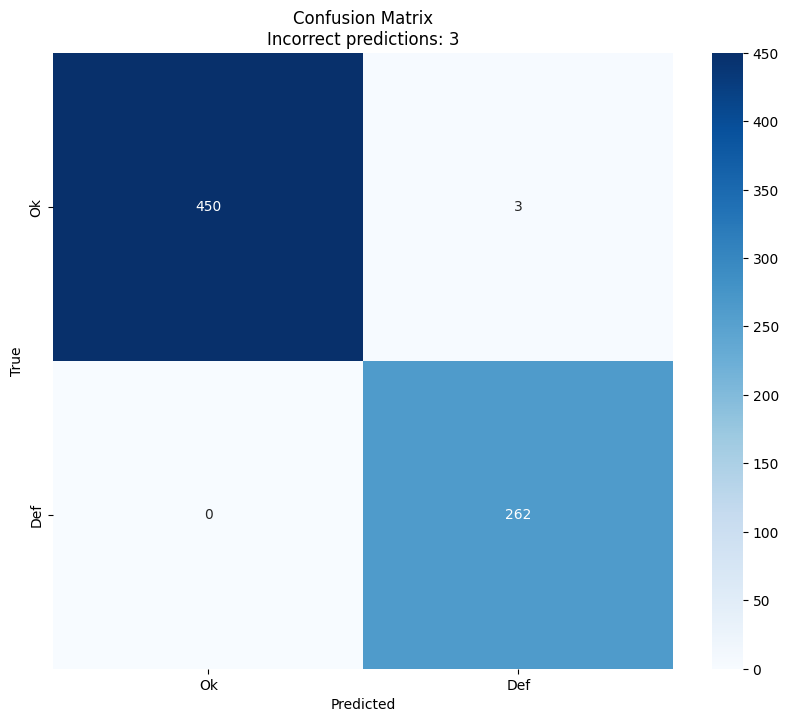

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# 재현 가능한 결과를 위해 랜덤 시드 설정
torch.manual_seed(42)
np.random.seed(42)

# 변수 초기화
num_correct = 0
num_total = 0
num_incorrect = 0

# 클래스별 정답 개수 및 맞춘 개수를 저장할 리스트 초기화
class_correct = [0] * num_classes
class_total = [0] * num_classes

# 실제 클래스와 예측된 클래스를 저장할 리스트 초기화
true_classes = []
predicted_classes = []

# 예측 수행
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # 모델 예측
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # 정확도 및 잘못 분류된 이미지 개수 계산
        num_correct += torch.sum(predicted == labels).item()
        num_total += labels.size(0)
        num_incorrect += torch.sum(predicted != labels).item()

        # 클래스별 정답 개수 및 맞춘 개수 계산
        for i in range(len(predicted)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1
            
        # 실제 클래스와 예측된 클래스 저장
        true_classes.extend(labels.cpu().numpy())
        predicted_classes.extend(predicted.cpu().numpy())

# 정확도 계산
accuracy = num_correct / num_total

# 결과 출력
if num_incorrect == 0:
    print("No incorrectly classified images")
else:
    print("Number of incorrectly classified images:", num_incorrect)

print("Accuracy:", accuracy)

# 클래스별 정답 개수 및 맞춘 개수 출력
for i in range(num_classes):
    print('Accuracy of %s : %d/%d' % (classes[i], class_correct[i], class_total[i]))

# Confusion Matrix 생성
cm = confusion_matrix(true_classes, predicted_classes)

# 클래스 이름 설정
class_names = classes

# Confusion Matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix\nIncorrect predictions: {}'.format(num_incorrect))  # 잘못 예측한 이미지 수 포함
plt.show()

In [12]:
CAM_images = []
# true_classes와 predicted_classes에서 라벨 값이 1로 같은 이미지의 인덱스 찾기
same_label_indices = [i for i, (true_label, predicted_label) in enumerate(zip(true_classes, predicted_classes)) if true_label == 1 and predicted_label == 1]

# same_label_indices에 해당하는 이미지를 전부 불러와서 CAM_images에 저장
for idx in same_label_indices:
    image, _ = test_loader.dataset[idx]
    file_path = test_loader.dataset.imgs[idx][0]  # 파일 경로는 test_loader.dataset.imgs에 저장되어 있음
    CAM_images.append((image, file_path))

# CAM_images 리스트에 저장된 이미지의 개수 출력
print("Number of images in CAM_images:", len(CAM_images))

Number of images in CAM_images: 262


In [21]:
pip install torchcam

   ---------------------------------------- 0.0/46.0 kB ? eta -:--:--
   ---------------------------------------- 46.0/46.0 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [13]:
# Set your CAM extractor
#https://github.com/frgfm/torch-cam

from torchcam.methods import SmoothGradCAMpp
cam_extractor = SmoothGradCAMpp(model)

In [14]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet18
from torchcam.methods import SmoothGradCAMpp

n=80

# Get your input
img = CAM_images[n][0]

#get image path
selected_image_path = CAM_images[n][1]

print("Selected image path:", selected_image_path)

# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
input_tensor = input_tensor.to(device)  # input_tensor를 GPU로 이동
with torch.no_grad():
    out = model(input_tensor.unsqueeze(0).to(device))

                         
with SmoothGradCAMpp(model) as cam_extractor:
  # Preprocess your data and feed it to the model
  out = model(input_tensor.unsqueeze(0))
  # Retrieve the CAM by passing the class index and the model output
  activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

Selected image path: C:\Users\noname\Desktop\Casting\casting_data\test\def_front\cast_def_0_2392.jpeg


RuntimeError: cannot register a hook on a tensor that doesn't require gradient

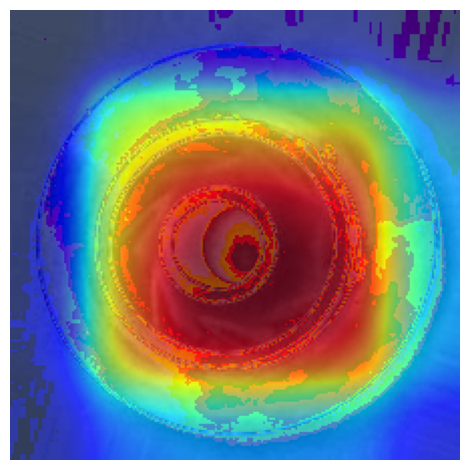

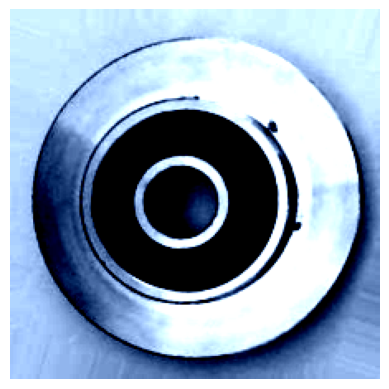

In [107]:
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

#Kernel Dead 방지 코드
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

#CAM을 원본 이미지에 덮어씌우기
result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.3)
#CAM 히트맵 출력
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

#원본 이미지 출력
plt.imshow(img.permute(1, 2, 0))  # 이미지를 RGB 형식으로 변환하여 출력
plt.axis('off')
plt.show()

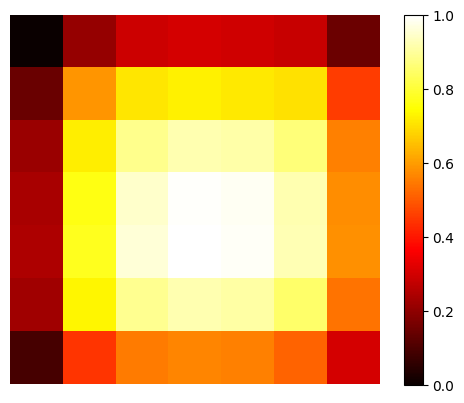

[tensor([[[0.0000, 0.2081, 0.2913, 0.3014, 0.2951, 0.2847, 0.1480],
          [0.1422, 0.5862, 0.7072, 0.7240, 0.7125, 0.7013, 0.4570],
          [0.2183, 0.7215, 0.8858, 0.9203, 0.9113, 0.8660, 0.5580],
          [0.2363, 0.7620, 0.9490, 0.9942, 0.9863, 0.9185, 0.5767],
          [0.2445, 0.7766, 0.9600, 1.0000, 0.9897, 0.9242, 0.5818],
          [0.2233, 0.7325, 0.8899, 0.9197, 0.9082, 0.8477, 0.5364],
          [0.0922, 0.4430, 0.5488, 0.5647, 0.5567, 0.5148, 0.3045]]],
        device='cuda:0')]

In [108]:
#CAM 히트맵과 수치값 확인

plt.imshow(activation_map[0].squeeze(0).cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.axis('off')
plt.colorbar()
plt.show()

activation_map

In [28]:
pip install opencv-python


   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/38.6 MB 2.0 MB/s eta 0:00:19
   - -------------------------------------- 1.6/38.6 MB 25.1 MB/s eta 0:00:02
   - -------------------------------------- 1.8/38.6 MB 16.5 MB/s eta 0:00:03
   -- ------------------------------------- 2.0/38.6 MB 12.9 MB/s eta 0:00:03
   -- ------------------------------------- 2.3/38.6 MB 11.1 MB/s eta 0:00:04
   -- ------------------------------------- 2.5/38.6 MB 10.1 MB/s eta 0:00:04
   -- ------------------------------------- 2.8/38.6 MB 9.3 MB/s eta 0:00:04
   --- ------------------------------------ 3.0/38.6 MB 8.6 MB/s eta 0:00:05
   --- ------------------------------------ 3.2/38.6 MB 8.2 MB/s eta 0:00:05
   --- ------------------------------------ 3.5/38.6 MB 7.9 MB/s eta 0:00:05
   --- ------------------------------------ 3.7/38.6 MB 7.6 MB/s eta 0:00:05
   ---- ----------------------------------- 3.9/38.6 MB 7.3 MB/s eta 0:00:05


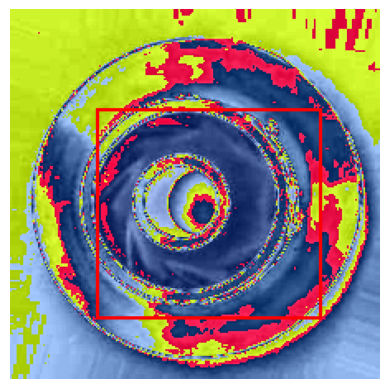

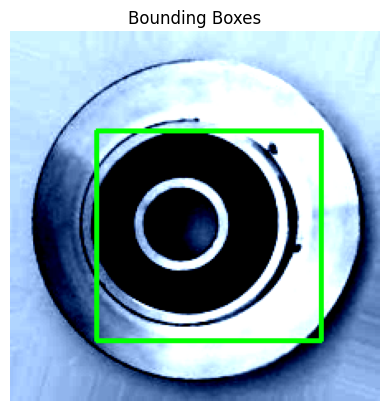

In [110]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import ImageDraw

#CAM의 히트맵 사이즈를 이미지와 같게 조정
cam_resized = cv2.resize(activation_map[0].squeeze(0).cpu().detach().numpy(), (img.shape[1], img.shape[2]))


#임계값 이상을 가진 영역만 활성화하여 binary_map에 할당
threshold = 0.8  #you may need to adjust this threshold based on your activation map
binary_map = cam_resized.squeeze() > threshold

# binary map의 contour 찾기
contours, _ = cv2.findContours(np.uint8(binary_map), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#바운딩박스 그리기
result_img = to_pil_image(img).convert("RGB")
draw = ImageDraw.Draw(result_img)
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    draw.rectangle([x, y, x+w, y+h], outline="red", width=2)

#히트맵이 있는 상태에서 바운딩박스 출력
plt.imshow(result_img)
plt.axis('off')
plt.show()

# 원본 이미지에 바운딩박스 그리기
img_np = np.array(img)
img_cv2 = cv2.cvtColor(img_np.transpose(1, 2, 0), cv2.COLOR_RGB2BGR)


for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)

#바운딩박스 그리기
    cv2.rectangle(img_cv2, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green color, thickness: 2

#원본 이미지에 바운딩박스 출력
plt.imshow(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))
plt.title('Bounding Boxes')
plt.axis('off')
plt.show()

# 팝업창으로 이미지 출력
#cv2.imshow('Bounding Box', img_cv2)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

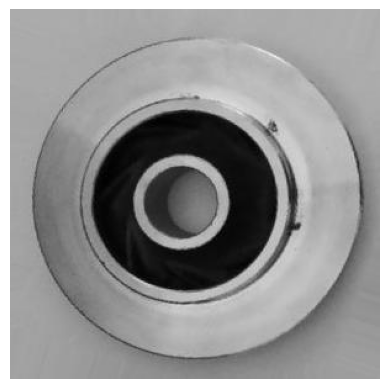

In [111]:
import matplotlib.pyplot as plt

# 파일 경로에 있는 이미지를 불러옵니다.
image = Image.open(selected_image_path)

# 이미지를 출력합니다.
plt.imshow(image)
plt.axis('off')  # 이미지 축 제거
plt.show()

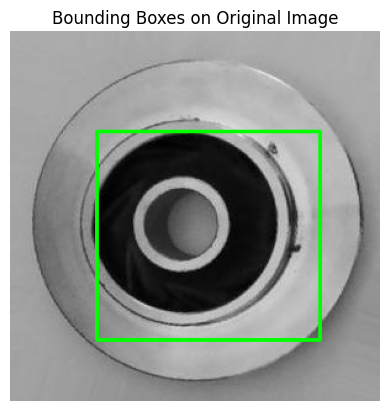

In [116]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision.transforms.functional import to_pil_image
from PIL import ImageDraw

# 이미지 파일을 읽어옵니다.
img3 = cv2.imread(selected_image_path)

# CAM의 히트맵 사이즈를 이미지와 같게 조정
cam_resized = cv2.resize(activation_map[0].squeeze(0).cpu().detach().numpy(), (img3.shape[1], img3.shape[0]))

# 임계값 이상을 가진 영역만 활성화하여 binary_map에 할당
threshold = 0.8  # you may need to adjust this threshold based on your activation map
binary_map = cam_resized > threshold

# binary map의 contour 찾기
contours, _ = cv2.findContours(np.uint8(binary_map), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 원본 이미지에 바운딩 박스 그리기
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(img3, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green color, thickness: 2

# 바운딩 박스가 그려진 이미지 출력
plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
plt.title('Bounding Boxes on Original Image')
plt.axis('off')
plt.show()